In [1]:
# Importing required libraries

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pytesseract
from PIL import Image, ImageDraw, ImageFont
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D
from transformers import LayoutLMTokenizer, LayoutLMForSequenceClassification, AdamW
import torch
from tqdm.auto import tqdm
import pickle

In [2]:
all_labels = {"email": 0, "resume": 1, "scientific_publication": 2}
indexes = {0: "email", 1: "resume", 2: "scientific_publication"}

In [3]:
# Creating Dataframe with two columns namely image_path and image_label

imagepaths = []
imagelabels = []

fileslist = os.listdir("Dataset")

for f in fileslist:
    images = os.listdir("Dataset/" + str(f))
    for i in images:
        ipath = "Dataset/" + str(f) + "/" + str(i)
        imagepaths.append(ipath)
        imagelabels.append(f)
        
df = pd.DataFrame({"image_path": imagepaths, "image_label" : imagelabels})
train_df, test_df = train_test_split(df, test_size = 0.20, random_state = 0, stratify = df.image_label)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [4]:
# Specifying the local path of the tesseract

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [5]:
# Importing layoutlm tokenizer

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

In [6]:
# Applying OCR to extract words and their respective bounding boxes

def ocr(df):
    
    img = np.array(Image.open(df["image_path"]))
    results = pytesseract.image_to_data(img, output_type = "data.frame")
    results = results.replace(r'^\s*$', np.nan, regex = True)
    results = results.dropna().reset_index(drop = True)

    words = list(results["text"])
    words = [str(i) for i in words]

    coords = results[["left", "top", "width", "height"]]
    bbox = []
    for index, row in coords.iterrows():
        left, top, width, height = tuple(row)
        box = [left, top, left + width, top + height] 
        bbox.append(box)

    df["words"] = words
    df["bbox"] = bbox
    return df

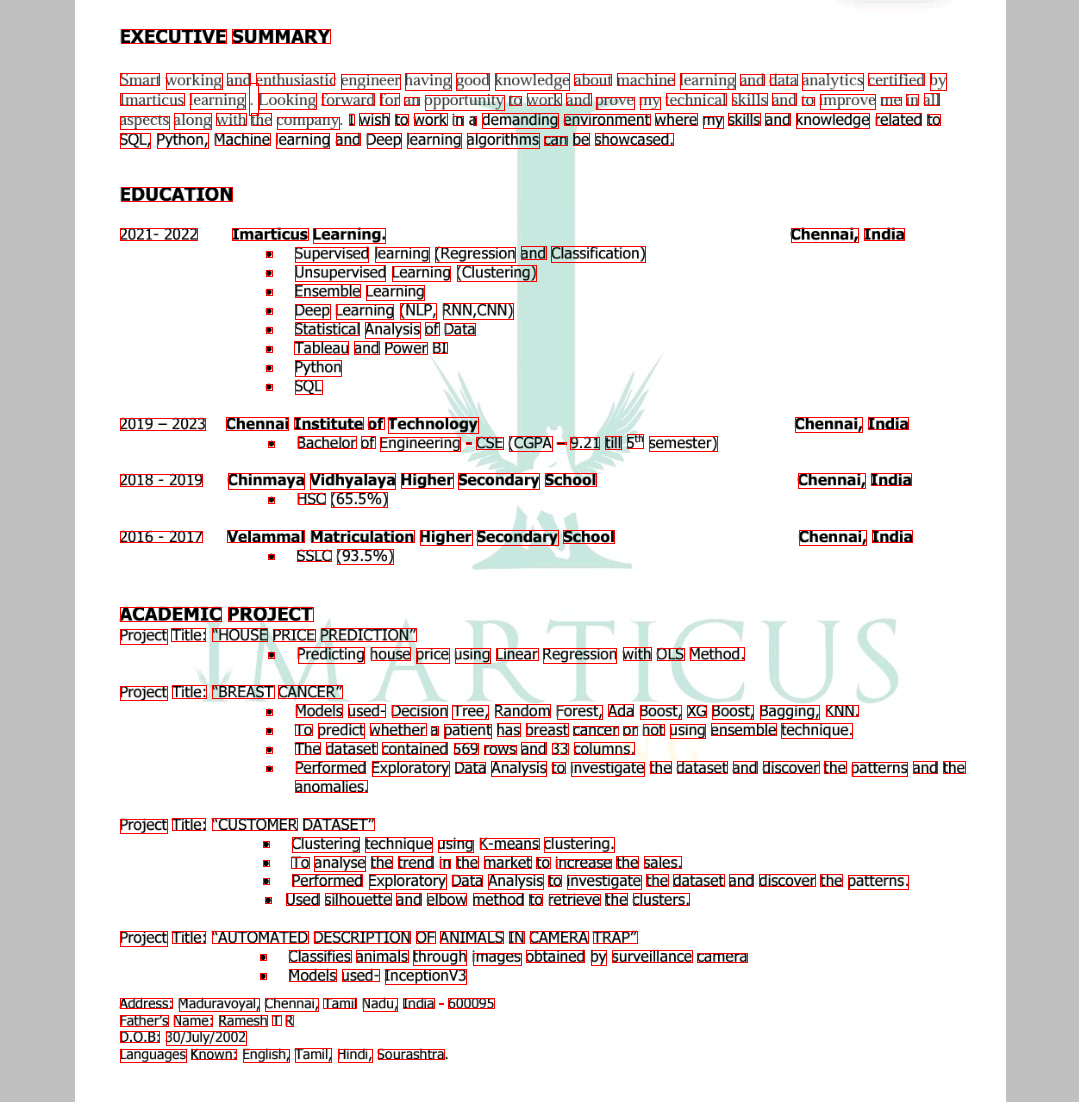

In [27]:
image = Image.open(r"C:\Users\arjun\OneDrive\Desktop\Screenshot_20220721_134632.jpg")
image = image.convert("RGB")
result = pytesseract.image_to_data(image, output_type = "data.frame")
result = result.replace(r'^\s*$', np.nan, regex = True)
result = result.dropna().reset_index(drop = True)

word = list(result["text"])
word = [str(i) for i in word]

coord = result[["left", "top", "width", "height"]]
b_box = []
for index, row in coord.iterrows():
    left, top, width, height = tuple(row)
    boxes = [left, top, left + width, top + height] 
    b_box.append(boxes)



draw = ImageDraw.Draw(image, "RGB")
for box in b_box:
    draw.rectangle(box, outline='red')

image

In [8]:
# Extracting token boxes

def generate_layoutlm_features(df, max_length = 512, pad_token_box = [0, 0, 0, 0]):
    words = df["words"]
    bbox = df["bbox"]

    token_boxes = []
    for word, box in zip(words, bbox):
        tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(tokens))

    x = 2 
    if len(token_boxes) > max_length - x:
        token_boxes = token_boxes[: (max_length - x)]

    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding = "max_length", truncation=True)
    input_ids = tokenizer(' '.join(words), truncation = True)["input_ids"]
    padding_length = max_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding["bbox"] = token_boxes
    encoding["image_label"] = all_labels[df["image_label"]]
    

    return encoding

In [9]:
# Training features

training_features = Features({
    "input_ids": Sequence(feature = Value(dtype = "int64")),
    "bbox": Array2D(dtype = "int64", shape = (512, 4)),
    "attention_mask": Sequence(Value(dtype = "int64")),
    "token_type_ids": Sequence(Value(dtype = "int64")),
    "image_label": ClassLabel(names = list(indexes.keys())),
    "image_path": Value(dtype = "string"),
    "words": Sequence(feature = Value(dtype = "string")),
})

In [10]:
# Function for dataloader

def dataloader(df):
    df = Dataset.from_pandas(df)
    df = df.map(ocr)
    df = df.map(lambda df: generate_layoutlm_features(df), features = training_features)
    df.set_format(type = "torch", columns = ["input_ids", "bbox", "attention_mask", "token_type_ids", "image_label"])
    dataloader = torch.utils.data.DataLoader(df, batch_size = 1, shuffle = True)
    batch = next(iter(dataloader))
    return dataloader

In [11]:
# Creating dataloader

train_dl = dataloader(train_df)
test_dl = dataloader(test_df)

Parameter 'function'=<function ocr at 0x000001C6AACB1D30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/132 [00:00<?, ?ex/s]

  0%|          | 0/132 [00:00<?, ?ex/s]

  0%|          | 0/33 [00:00<?, ?ex/s]

  0%|          | 0/33 [00:00<?, ?ex/s]

In [ ]:
# Load the model
# model = pickle.load(open(filename, 'rb'))

In [12]:
# Importing pretrained Layoutlm v1 model

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels = 3)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Training Model 

optimizer = AdamW(model.parameters(), lr = 5e-5)
num_train_epochs = 4
model.train()

for epoch in range(num_train_epochs):
    
    print("Epoch:", epoch)
    
    train_loss = 0.0
    train_correct = 0.0
    
    for batch in tqdm(train_dl):
        labels = batch["image_label"].to(device)
        input_ids = batch["input_ids"].to(device)
        bbox = batch["bbox"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["image_label"].to(device)
        outputs = model(input_ids = batch["input_ids"].to(device), bbox = batch["bbox"].to(device), attention_mask = batch["attention_mask"].to(device), token_type_ids = batch["token_type_ids"].to(device), labels = batch["image_label"].to(device))
        loss = outputs.loss
        
        train_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        train_correct += (predictions == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print("Loss in Training : ", train_loss / batch["input_ids"].shape[0])
    Train_Accuracy = 100 * train_correct / len(train_df)
    print("Training Accuracy : ", Train_Accuracy.item())  

    test_loss = 0.0
    test_correct = 0.0
    for batch in tqdm(test_dl):
        labels = batch["image_label"].to(device)
        input_ids = batch["input_ids"].to(device)
        bbox = batch["bbox"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["image_label"].to(device)
        outputs = model(input_ids = batch["input_ids"].to(device), bbox = batch["bbox"].to(device), attention_mask = batch["attention_mask"].to(device), token_type_ids = batch["token_type_ids"].to(device), labels = batch["image_label"].to(device))
        loss = outputs.loss

        test_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        test_correct += (predictions == labels).float().sum()

    print("Loss in Testing : ", test_loss / batch["input_ids"].shape[0])
    Test_accuracy = 100 * test_correct / len(test_df)
    print("Testing accuracy : ", Test_accuracy.item())

Epoch: 0


C:\Users\arjun\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/132 [00:00<?, ?it/s]

Loss in Training :  51.687748769298196
Training Accuracy :  83.33333587646484


  0%|          | 0/33 [00:00<?, ?it/s]

Loss in Testing :  1.0175867639482021
Testing accuracy :  100.0
Epoch: 1


  0%|          | 0/132 [00:00<?, ?it/s]

Loss in Training :  1.8120646416209638
Training Accuracy :  100.0


  0%|          | 0/33 [00:00<?, ?it/s]

Loss in Testing :  0.809718316886574
Testing accuracy :  100.0
Epoch: 2


  0%|          | 0/132 [00:00<?, ?it/s]

Loss in Training :  0.5926717477850616
Training Accuracy :  100.0


  0%|          | 0/33 [00:00<?, ?it/s]

Loss in Testing :  0.12823006184771657
Testing accuracy :  100.0
Epoch: 3


  0%|          | 0/132 [00:00<?, ?it/s]

Loss in Training :  0.36402394564356655
Training Accuracy :  100.0


  0%|          | 0/33 [00:00<?, ?it/s]

Loss in Testing :  0.21155264473054558
Testing accuracy :  100.0


In [24]:
# Save the model
# pickle.dump(model, open(filename, 'wb'))
pickle.dump(model, open("model.pkl", "wb"))

In [17]:
# Prediction

In [18]:
# Extracting token boxes

def generate_layoutlm_features_test(df, max_length = 512, pad_token_box = [0, 0, 0, 0]):
    words = df["words"]
    bbox = df["bbox"]

    token_boxes = []
    for word, box in zip(words, bbox):
        tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(tokens))

    x = 2 
    if len(token_boxes) > max_length - x:
        token_boxes = token_boxes[: (max_length - x)]

    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding = "max_length", truncation=True)
    input_ids = tokenizer(' '.join(words), truncation = True)["input_ids"]
    padding_length = max_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding["bbox"] = token_boxes
    

    return encoding

In [19]:
testing_features = Features({
    "input_ids": Sequence(feature = Value(dtype = "int64")),
    "bbox": Array2D(dtype = "int64", shape = (512, 4)),
    "attention_mask": Sequence(Value(dtype = "int64")),
    "token_type_ids": Sequence(Value(dtype = "int64")),
    "image_path": Value(dtype = "string"),
    "words": Sequence(feature = Value(dtype = "string")),
})

In [20]:
pred_df = pd.DataFrame({"image_path": ["Dataset/scientific_publication/doc_000016.png"]})
pred_df = Dataset.from_pandas(pred_df)
pred_df = pred_df.map(ocr)
pred_df = pred_df.map(lambda df: generate_layoutlm_features_test(df), features = testing_features)
pred_df.set_format(type = "torch", columns = ["input_ids", "bbox", "attention_mask", "token_type_ids"])
pred_df = torch.utils.data.DataLoader(pred_df, batch_size=1, shuffle=True)
batch = next(iter(pred_df))

outputs = model(input_ids = batch["input_ids"].to(device), bbox = batch["bbox"].to(device), attention_mask = batch["attention_mask"].to(device), token_type_ids = batch["token_type_ids"].to(device))
preds = torch.softmax(outputs.logits, dim = 1).tolist()[0]
pred_labels = {label : pred for label, pred in zip(all_labels.keys(), preds)}
pred_labels

  0%|          | 0/1 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ex/s]

{'email': 0.000697559560649097,
 'resume': 0.0006731772446073592,
 'scientific_publication': 0.9986293315887451}